*See README.md for a brief definition of the project.*

*This serie is composed by three notebooks:*
 - *exploratory_analysis.ipynb (this one);*
 - *pre_processing.ipynb; and*
 - *outlier_classification.ipynb.*

 
# **Exploratory Analysis**

This is a study of the problem (see README.md). The main objective is to understand the characteristics of the problem and which approach could be used to solve it.
Synthetic data were used to mimic the actual dataset.

---
**Caveats:** 

*Since this notebook is the first contact with the problem, it was developed as an experiment. So, the code organization was not made necessarily for reuse.*
*Even tough, some classes and ideas have been used in the next steps of development.*

## **Importing basic libraries**

In [13]:
import sys
import os
from os import path
from collections import defaultdict

import datetime
from datetime import datetime
import time
import traceback
import multiprocessing as mp

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools as itools

import re
import yaml
import glob

## **Utilities**

### class Directories

In [14]:

class Directories:
    
    SEP="/"
    
    def __init__(self, ambar_path=None, csv_dirname=None, dumps_dirname=None, verbose=False):
        self.ambar_path = ambar_path
        self.csv_dirname = csv_dirname
        self.dumps_dirname = dumps_dirname
        self.verbose = verbose
        
    def __str__(self):
        ret = "[ INFO ] Main directories:\n" + str(self.__dict__)
        return ret

### class log

In [15]:

from datetime import datetime

class log:

    def __print(msg="", label=None, date=True, newline=True, ret=False):

        msg_aux = "" 
        
        if date:
            str_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            msg_aux = msg_aux + f"<{str_time}> "
            
        if label is not None:
            str_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            msg_aux = msg_aux + f"[ {label} ] "
            
        msg_aux = msg_aux + f"{msg}"
        
        if newline:
            msg_aux = msg_aux + f"\n"

        print(f"{msg_aux}")
        
        if ret:
            return ret
        
    def line(newline=False, ret=False):
        log.__print(msg="---------------------------------------------------", date=False, newline=False)

    def printMessage(msg, newline=False):
        log.line()
        log.__print(msg=msg, newline=False)
        log.line()
        if newline:
            print("")
        
    def info(msg, ret=False):
        log.__print(label="INFO", msg=msg, ret=ret)
        
    def err(msg,ret=False):
        log.__print(label="ERROR", msg=msg,ret=ret)
        
    def warn(msg,ret=False):
        log.__print(label="WARN", msg=msg,ret=ret)
        
    def ok(ret=False):
        log.__print(label="OK", msg="",ret=ret)

## **Synthetic data related classes**

In [16]:
import numpy as np

class Work:
    def __init__(
            self, 
            num_workers=1, num_workers_per_node=1, app_name=None, app_version="b0.0.0", 
            processor_type="cpu", mem_gb=None, machine_name=None, 
            cluster_id=None, cluster_name=None,
            n=None
            ):
        self.num_workers  = num_workers
        self.num_workers_per_node = num_workers_per_node
        self.app_name = app_name
        self.app_version = app_version
        self.processor_type = processor_type
        self.mem_gb = mem_gb
        self.machine_name = machine_name
        
        self.cluster_id = cluster_id
        if cluster_name is None:
            self.cluster_name = "cluster_" + str(cluster_id)
        else:
            self.cluster_name = cluster_name
        
        self.n = n 
        self.execution_time_ms = None

    def __str__(self):
        return str(self.__dict__)


class SyntheticJob:
    def __init__( self, work: Work = None, std_deviation_perc=5, linear_coef_perc=5 ):
        self.work = work
        self.std_deviation = std_deviation_perc/100 
        self.linear_coef = linear_coef_perc/100
        self.median = None

    def produce_execution_times(self, n_samples : int):
        raise NotImplementedError

    def produce_exec_data(self, n_samples: int):
        exec_times, self.median, sd = self.produce_execution_times(n_samples)
        
        regs = dict()
        for k,v in self.work.__dict__.items():
            regs[k] = [v] * len(exec_times)
        regs["execution_time_ms"] = exec_times
        
        return regs, self.median, sd

    def __get_registry(self):
        reg = dict(self.work.__dict__)
        reg["median"] = self.median
        return reg

    def __str__(self):
        return str(self.__get_registry())


class SRME3D_SyntheticJob(SyntheticJob):
    def __init__( self, work: Work = None, std_deviation_perc=5, linear_coef_perc=5 ):
        super().__init__(work=work, std_deviation_perc=std_deviation_perc, linear_coef_perc=linear_coef_perc)

    def produce_execution_times(self, n_samples):
        median = self.work.n
        b = 20000 # 20 secs para montar a kdtree no srme
        std_dev = median * self.std_deviation
        
        rng = np.random.default_rng()
        values = b + rng.normal(median, std_dev, size=n_samples)
        
        return values, median, std_dev 


class RTM3D_SyntheticJob(SyntheticJob):
    def __init__( self, work: Work = None, std_deviation_perc=5, linear_coef_perc=5 ):
        super().__init__(work=work, std_deviation_perc=std_deviation_perc, linear_coef_perc=linear_coef_perc)

    def produce_execution_times(self, n_samples):
        median = self.work.n
        b = median*self.linear_coef
        std_dev = median * self.std_deviation
        
        rng = np.random.default_rng()
        values = b + rng.normal(median, std_dev, size=n_samples)
        
        return values, median, std_dev 
    
        

## **Defining important directories**

In [17]:


dirs = Directories( 
                          csv_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/datasets/synthetic",
                          ambar_path=None, 
                          dumps_dirname=None,
                         )

log.info(dirs)


<2023-07-07 15:09:15> [ INFO ] [ INFO ] Main directories:
{'ambar_path': None, 'csv_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/datasets/synthetic', 'dumps_dirname': None, 'verbose': False}



## **Creating synthetic job execution**

A job execution is a set of works (tasks) sharing the same attributes. 
Just the execution time changes from an work to another.

<2023-07-07 15:09:15> [ INFO ] [ 0 ] 'srme', j = {'num_workers': 1, 'num_workers_per_node': 24, 'app_name': 'srme3d', 'app_version': 'b0.0.0', 'processor_type': 'cpu', 'mem_gb': 64, 'machine_name': 'andromeda', 'cluster_id': 1, 'cluster_name': 'cluster_1', 'n': 2000, 'execution_time_ms': None, 'median': None}

<2023-07-07 15:09:15> [ INFO ] [ 1 ] 'rtm', j = {'num_workers': 4, 'num_workers_per_node': 1, 'app_name': 'rtm3d', 'app_version': 'b0.0.0', 'processor_type': 'gpu', 'mem_gb': 32, 'machine_name': 'atlas', 'cluster_id': 2, 'cluster_name': 'cluster_2', 'n': 2000, 'execution_time_ms': None, 'median': None}

<2023-07-07 15:09:15> [ INFO ] [ 0 ] 'srme', j = {'num_workers': 1, 'num_workers_per_node': 24, 'app_name': 'srme3d', 'app_version': 'b0.0.0', 'processor_type': 'cpu', 'mem_gb': 64, 'machine_name': 'andromeda', 'cluster_id': 1, 'cluster_name': 'cluster_1', 'n': 2000, 'execution_time_ms': None, 'median': 2000}

<2023-07-07 15:09:15> [ INFO ] [ 1 ] 'rtm', j = {'num_workers': 4, 'num

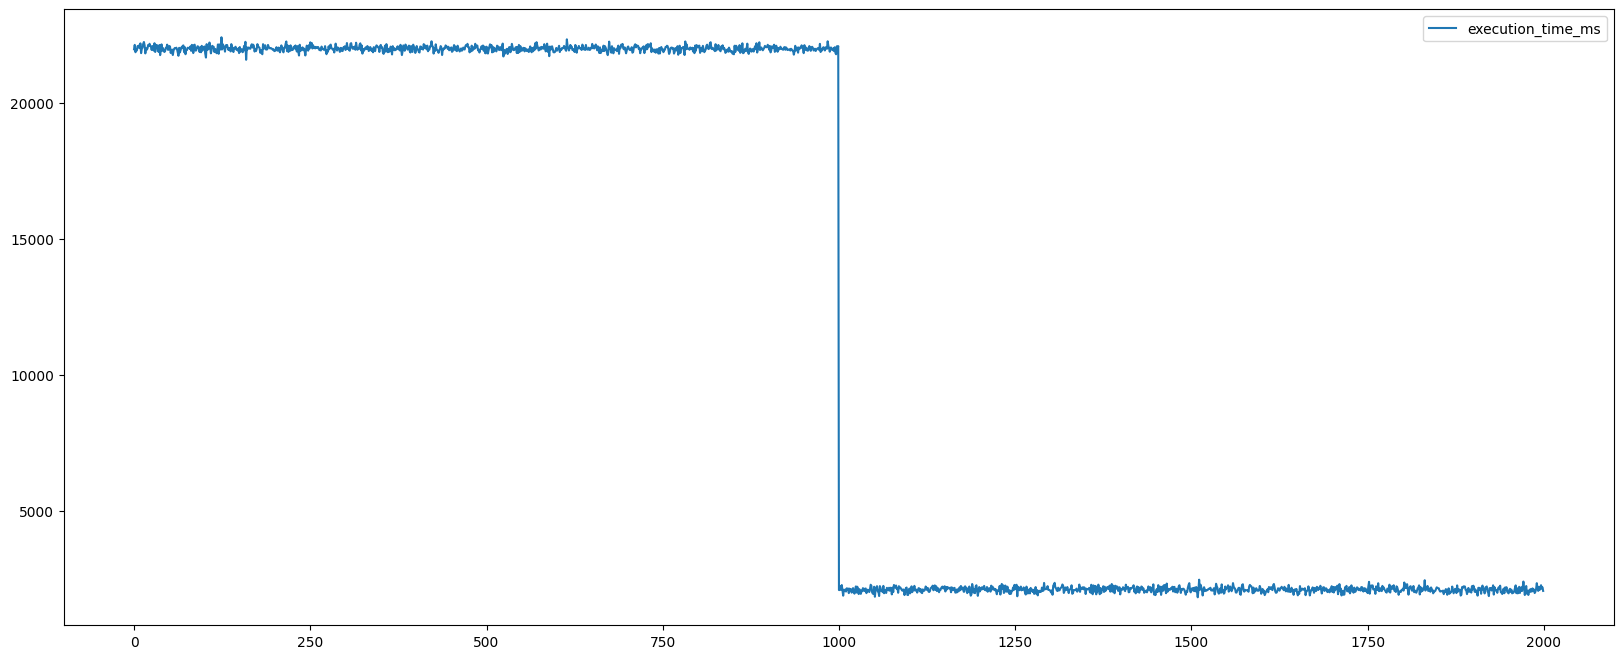

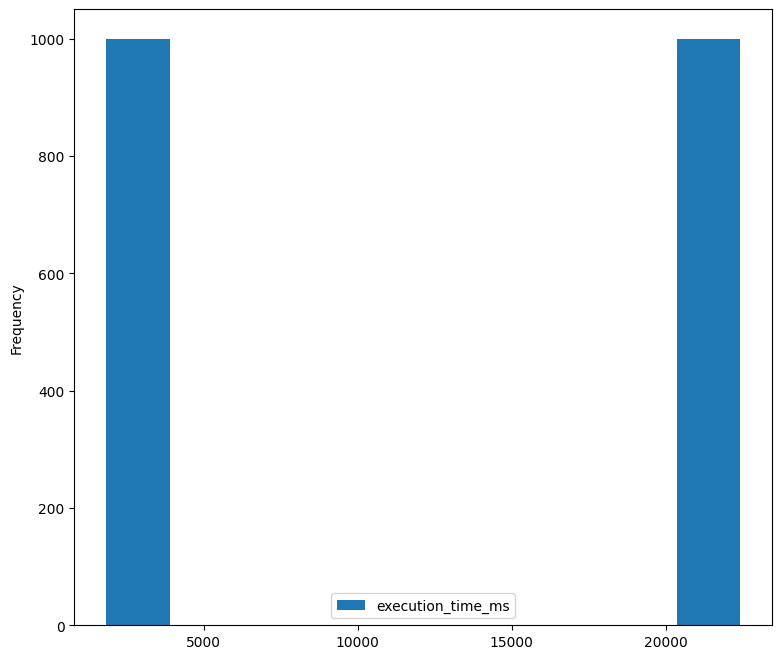

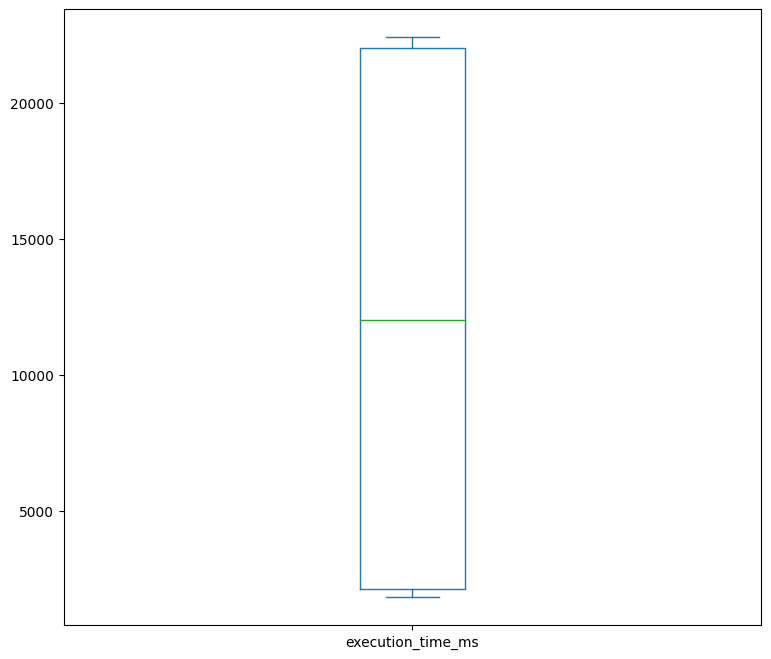

In [18]:
jobs = {
    "srme" : SRME3D_SyntheticJob(
        Work(
            num_workers=1, num_workers_per_node=24, app_name="srme3d", processor_type="cpu", 
            mem_gb=64, machine_name="andromeda", cluster_id=1, n=2000
            )
        ),
    "rtm" : RTM3D_SyntheticJob( 
            Work(
                num_workers=4, num_workers_per_node=1, app_name="rtm3d", processor_type="gpu", 
                mem_gb=32, machine_name="atlas", cluster_id=2, n=2000
                )
            ),
    }



df_table = pd.DataFrame()
for i,(n,j) in enumerate(jobs.items()):
    log.info(f"[ {i} ] '{n}', j = {j}")
    registries, median, std_dev = j.produce_exec_data(10)
    #log.info(f"median = {median}, real_std_dev = {std_dev}")
    #log.info(f"registries = {str(registries)}")
    df_aux = pd.DataFrame(registries)
    df_table = pd.concat([df_table, df_aux], ignore_index=True)

df_table


df_table = pd.DataFrame()
for i,(n,j) in enumerate(jobs.items()):
    log.info(f"[ {i} ] '{n}', j = {j}")
    registries, median, std_dev = j.produce_exec_data(1000)
    df_aux = pd.DataFrame(registries)
    df_table = pd.concat([df_table, df_aux], ignore_index=True)
    
print(df_table.head())
log.line()
print(df_table.describe())
log.line()
df_table.plot(y=["execution_time_ms"], kind="line", figsize=(20, 8), use_index=True)
df_table.plot(y=["execution_time_ms"], kind="hist", figsize=(9, 8), use_index=True)
df_table.plot(y=["execution_time_ms"], kind="box", figsize=(9, 8), use_index=True)
plt.show()






## **Creating a set of synthetic jobs**
First, we will define the classes.


In [19]:
# produce all job simulations parameters of srme
class JobGrid:
    def __init__(self, dictionary : dict = None):
        self.dict = dictionary
        self.grid = [dict(zip(self.dict, v)) for v in itools.product(*self.dict.values())]


class SRME3D_JobGrid(JobGrid):
    def __init__(self):
        super().__init__(
            dictionary = { "num_workers" : [1], "num_workers_per_node" : [24], "app_name" : ["srme3d"], "processor_type" : ["cpu"], 
            "mem_gb" : ["64"], "machine_name" : ["andromeda"], "cluster_id" : ["dummy"], "n" : range(1,30000, 1000) # 10)
            }
        )

class RTM3D_JobGrid(JobGrid):
    def __init__(self):
        nxo = 55
        nyo = 55
        nzo = 25
        nto = 2000/4
        no = nxo*nyo*nzo*nto
        nf = 10*nxo*10*nyo*10*nzo*4*nto
        step = (nf-no)/100
        super().__init__(
            dictionary = { "num_workers" : [4], "num_workers_per_node" : [1], "app_name" : ["rtm3d"], "processor_type" : ["gpu"], 
            "mem_gb" : ["32"], "machine_name" : ["atlas"], "cluster_id" : ["dummy"], "n" : range(int(no), int(nf), int(step))
            }
        )
# produce all job simulations execution of srme
class AllJobsSimulation:
    
    #g_list_dfs = None
    
    def __init__(self, grid : JobGrid = None, std_deviation_perc=5, linear_coef_perc=5, n_samples=1000):
        self.obj_grid = grid
        self.std_deviation_perc = std_deviation_perc
        self.linear_coef_perc = linear_coef_perc
        self.n_samples = n_samples
        
    def produce_one_simulation(self, cluster_id, job_parameters):
        raise NotImplementedError 
        
    def treat_error(error):
        log.err(f"Error code: {error}")
        
    def collect_results(result):
        """Uses apply_async's callback to setup up a separate Queue for each process"""
        log.info(f"Collecting result = {len(result)}")
        AllJobsSimulation.g_list_dfs.append(pd.DataFrame(result))
        
    #def produce_job_simulations(self, parallel=False, num_threads=None, verbose=False):
    def produce_job_simulations(self, verbose=False):
        
        start_time = time.time()
        
        list_dfs = []
        
#        if parallel:
#            raise NotImplementedError 
#            if num_threads is None:
#                num_threads = min(mp.cpu_count(),len(self.obj_grid.grid))
#                
#            if verbose:  
#                log.info(f" Parallel computing of simulations with {num_threads} threads!")
#                
#            pool = mp.Pool(processes=num_threads)
#
#            for i, g in enumerate(self.obj_grid.grid):
#                pool.apply_async(
#                    self.produce_one_simulation, args = (i, g), 
#                    callback = AllJobsSimulation.collect_results,
#                    error_callback = AllJobsSimulation.treat_error
#                    )    
#            pool.close()
#            pool.join()
#                
#        else:
        for i, g in enumerate(self.obj_grid.grid):
            regs = self.produce_one_simulation(i, g)
            df_aux = pd.DataFrame(regs)
            list_dfs.append(df_aux)
        
        df = pd.concat(list_dfs, ignore_index=True, axis=0)
                    
        end_time = time.time()
        
        if verbose:
            log.info(f'Time to produce simulations: {end_time - start_time} (secs)')
        
        return df


class SRME3D_AllJobsSimulation(AllJobsSimulation):
    
    def __init__(self, grid : SRME3D_JobGrid = None, std_deviation_perc=7,  n_samples=1000):
        super().__init__(grid=grid, std_deviation_perc=std_deviation_perc, n_samples=n_samples)
    
    def produce_one_simulation(self, cluster_id, job_parameters):
        job_parameters["cluster_id"] = cluster_id
        synt = SRME3D_SyntheticJob(Work(**job_parameters), std_deviation_perc=self.std_deviation_perc )
        regs, median, std_dev = synt.produce_exec_data(self.n_samples)
        return regs


class RTM3D_AllJobsSimulation(AllJobsSimulation):
    
    def __init__(self, grid : RTM3D_JobGrid = None, std_deviation_perc=5,  linear_coef_perc=3, n_samples=1000):
        super().__init__(grid=grid, std_deviation_perc=std_deviation_perc, n_samples=n_samples)
    
    def produce_one_simulation(self, cluster_id, job_parameters):
        job_parameters["cluster_id"] = cluster_id
        synt = RTM3D_SyntheticJob(Work(**job_parameters), std_deviation_perc=self.std_deviation_perc, linear_coef_perc=self.linear_coef_perc )
        regs, median, std_dev = synt.produce_exec_data(self.n_samples)
        return regs





Then, we are able to create a set o different jobs, each of which has potencially different attributes.

In [20]:

job_grids = {
     "srme" : SRME3D_AllJobsSimulation(SRME3D_JobGrid(), std_deviation_perc=5, n_samples=100),#10000) 
     "rtm" : RTM3D_AllJobsSimulation(RTM3D_JobGrid(), std_deviation_perc=5, n_samples=100),#10000) 
     }

jobs_list = list()
for i,(k,g) in enumerate(job_grids.items()):
     log.info(f"[ {i} ] Generating {len(g.obj_grid.grid)} synthetic {k} jobs with {g.n_samples} tasks each...")
     #df_srme = srme_all_jobs.produce_job_simulations(parallel=True, verbose=True)  # it is take too long. I thing the collection is serial
     jobs_list.append( pd.DataFrame(g.produce_job_simulations(verbose=True)))
     log.ok()

df_all_jobs = pd.concat(jobs_list, ignore_index=True)

<2023-07-07 15:09:15> [ INFO ] [ 0 ] Generating 30 synthetic srme jobs with 100 tasks each...

<2023-07-07 15:09:15> [ INFO ] Time to produce simulations: 0.028226852416992188 (secs)

<2023-07-07 15:09:15> [ OK ] 

<2023-07-07 15:09:15> [ INFO ] [ 1 ] Generating 100 synthetic rtm jobs with 100 tasks each...

<2023-07-07 15:09:15> [ INFO ] Time to produce simulations: 0.0893707275390625 (secs)

<2023-07-07 15:09:15> [ OK ] 



In [21]:

#df_all_jobs.describe()
df_all_jobs
#df_srme.tail()
#df_srme.head()
#print(len(df_srme))


,num_workers,num_workers_per_node,app_name,app_version,processor_type,mem_gb,machine_name,cluster_id,cluster_name,n,execution_time_ms
0,1,24,srme3d,b0.0.0,cpu,64,andromeda,0,cluster_0,1,2.000113e+04
1,1,24,srme3d,b0.0.0,cpu,64,andromeda,0,cluster_0,1,2.000103e+04
2,1,24,srme3d,b0.0.0,cpu,64,andromeda,0,cluster_0,1,2.000092e+04
3,1,24,srme3d,b0.0.0,cpu,64,andromeda,0,cluster_0,1,2.000099e+04
4,1,24,srme3d,b0.0.0,cpu,64,andromeda,0,cluster_0,1,2.000103e+04
...,...,...,...,...,...,...,...,...,...,...,...
12995,4,1,rtm3d,b0.0.0,gpu,32,atlas,99,cluster_99,149737878125,1.567403e+11
12996,4,1,rtm3d,b0.0.0,gpu,32,atlas,99,cluster_99,149737878125,1.495023e+11
12997,4,1,rtm3d,b0.0.0,gpu,32,atlas,99,cluster_99,149737878125,1.643178e+11
12998,4,1,rtm3d,b0.0.0,gpu,32,atlas,99,cluster_99,149737878125,1.655923e+11


### Some graphics for analysis

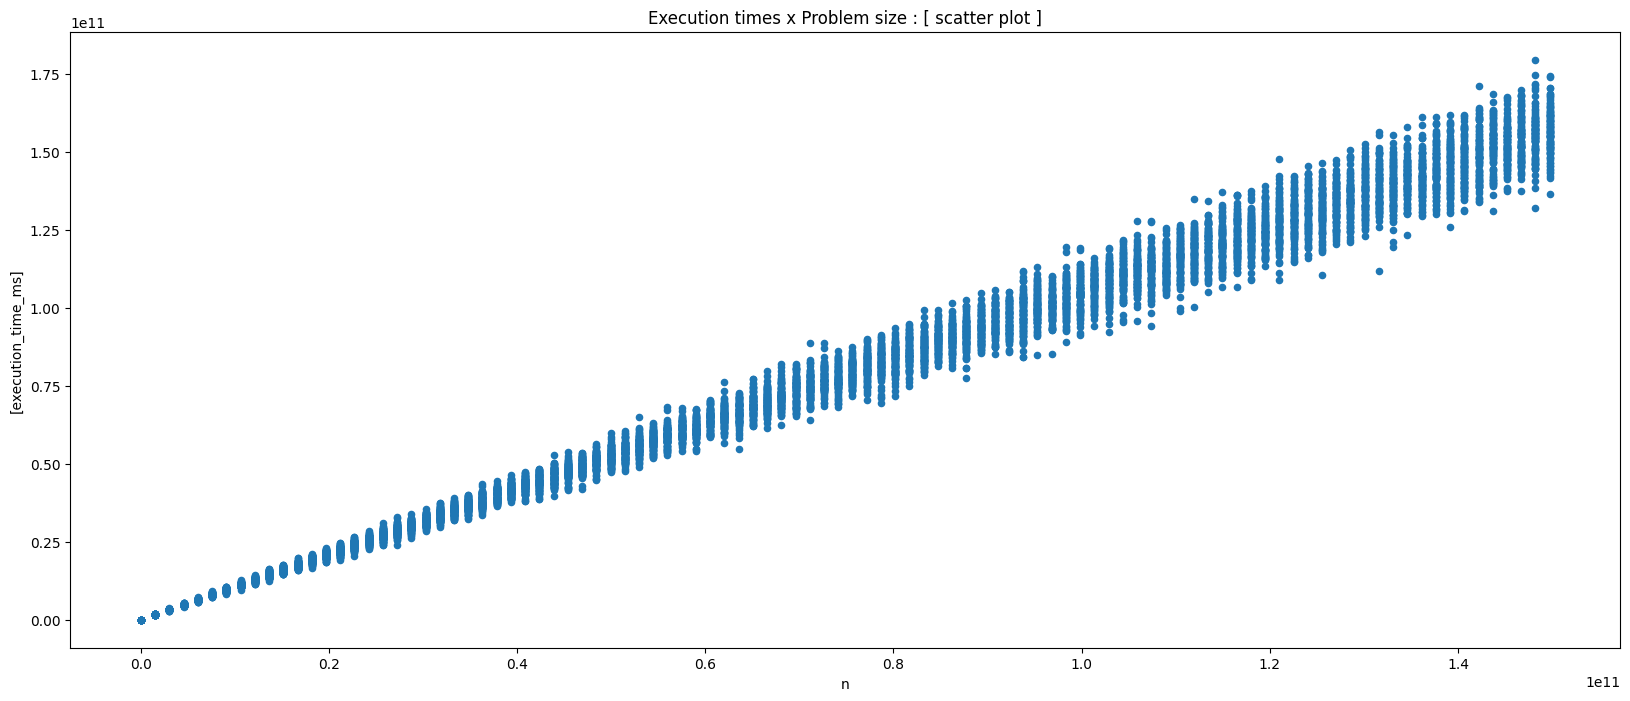

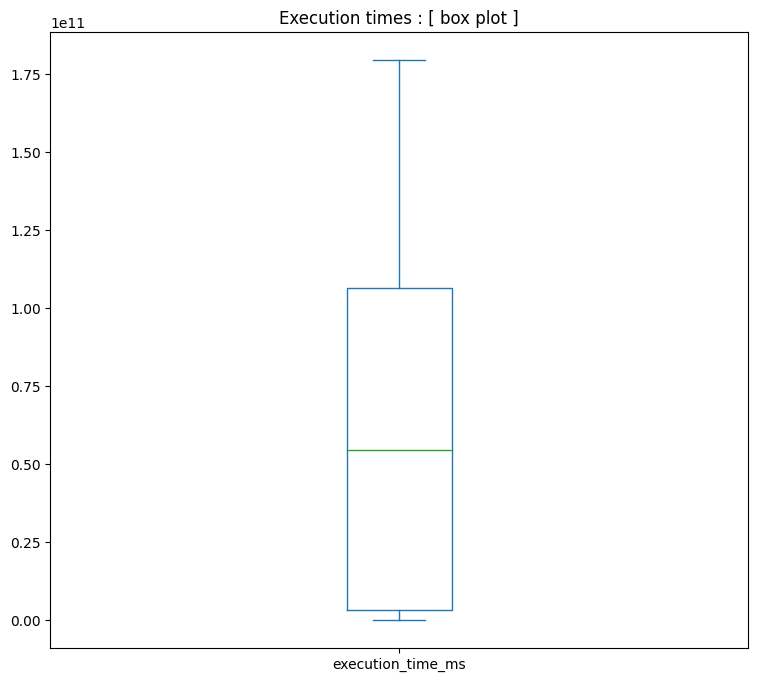

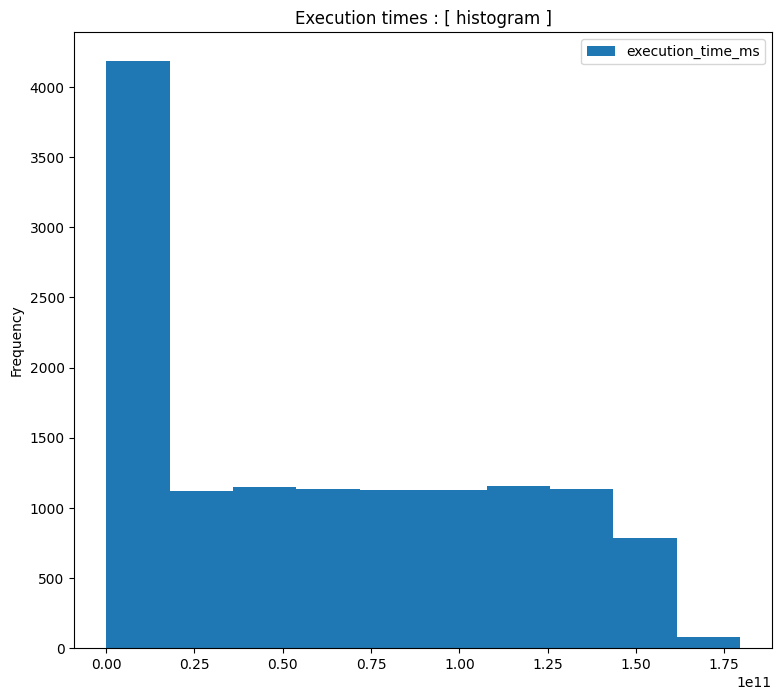

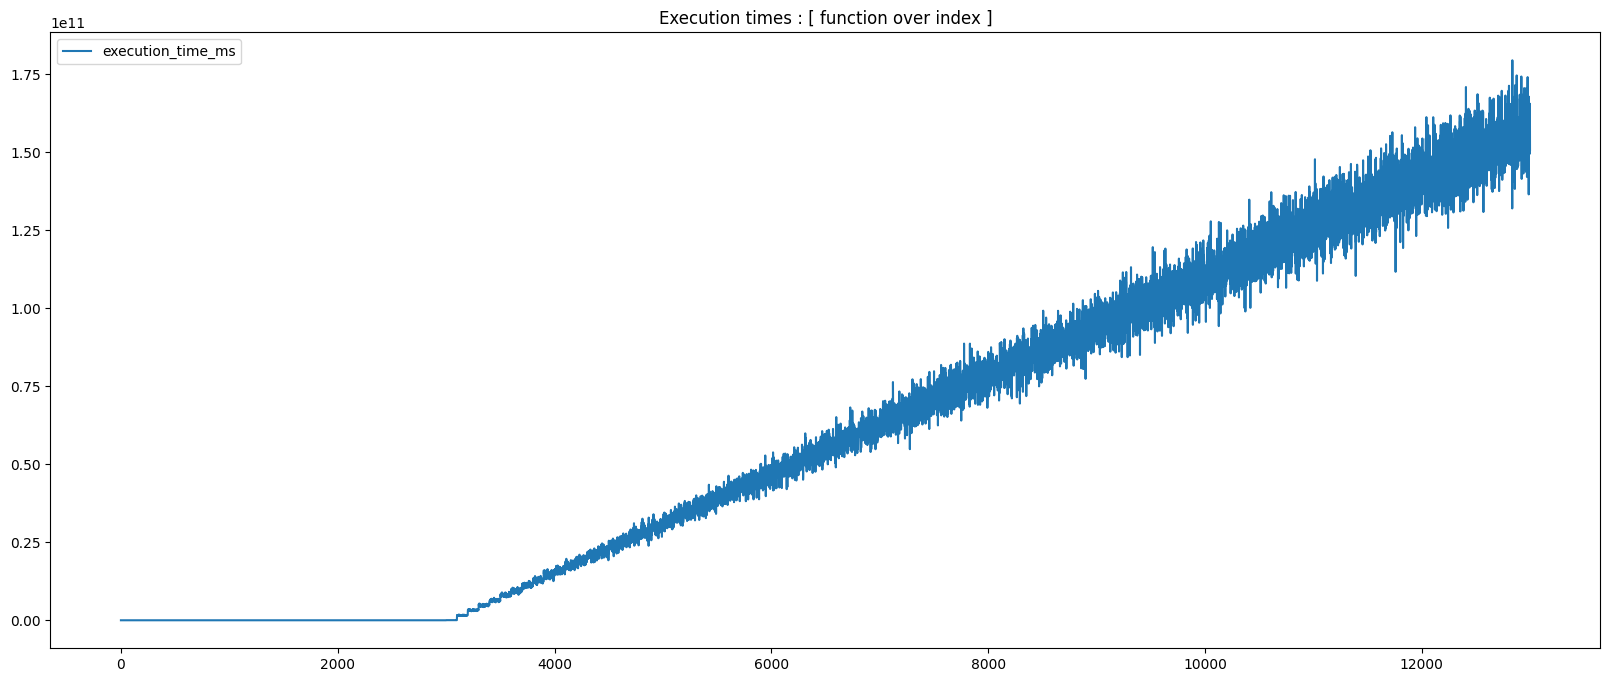

In [22]:

df_all_jobs.plot(x="n", y=["execution_time_ms"], kind="scatter", figsize=(20, 8))#, use_index=True)
plt.title("Execution times x Problem size : [ scatter plot ]")
df_all_jobs.plot(y=["execution_time_ms"], kind="box", figsize=(9, 8))
plt.title("Execution times : [ box plot ]")
df_all_jobs.plot(y=["execution_time_ms"], kind="hist", figsize=(9, 8))
plt.title("Execution times : [ histogram ]")
df_all_jobs.plot(y=["execution_time_ms"], kind="line", figsize=(20, 8), use_index=True)
plt.title("Execution times : [ function over index ]")
plt.show()




## **Model testing**

13000


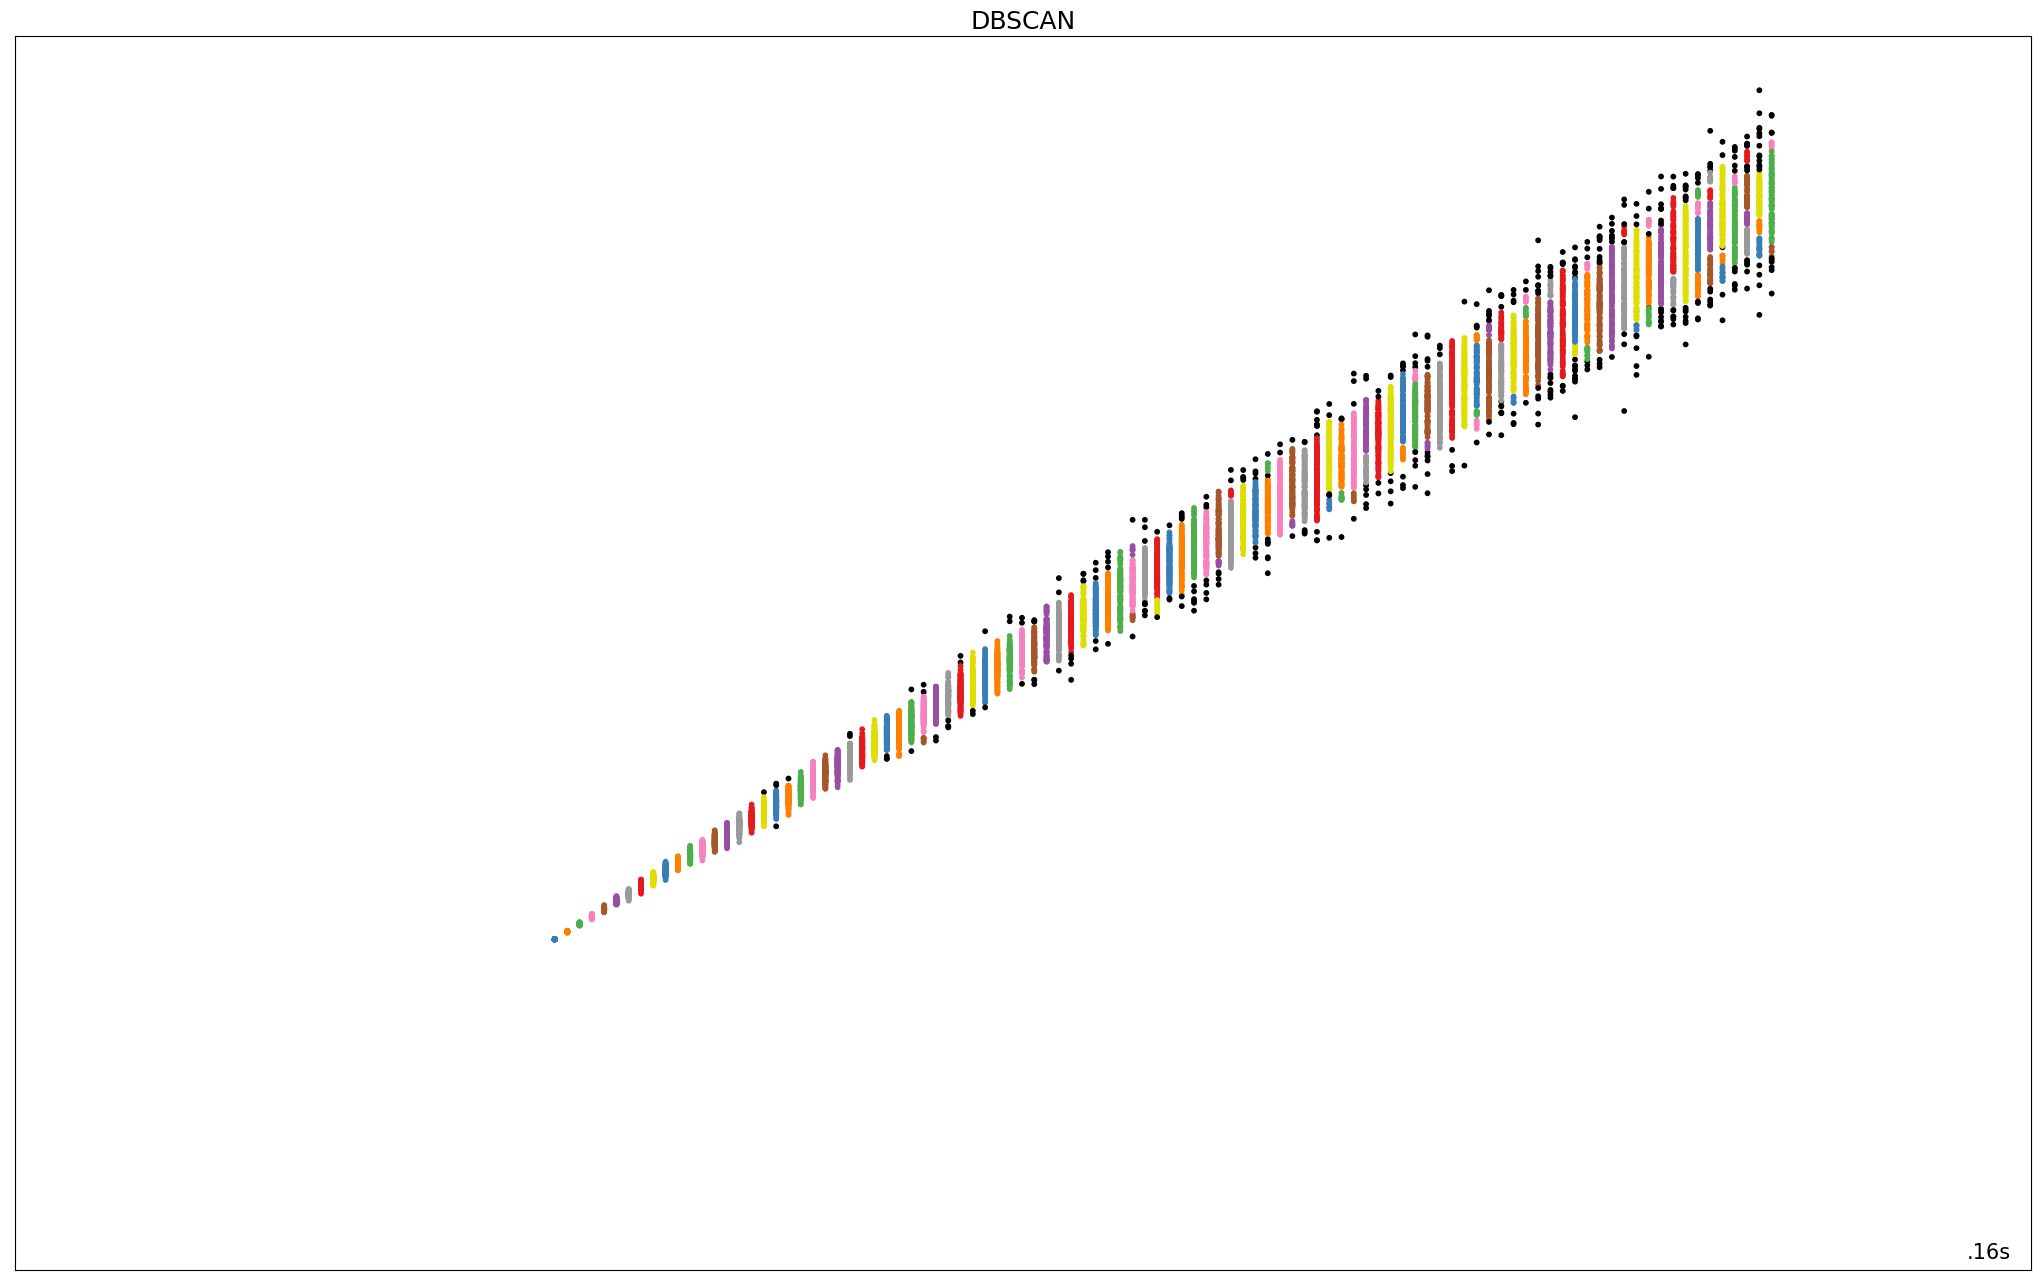

In [23]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
all_dataset = np.array([ df_all_jobs["n"], df_all_jobs["execution_time_ms"]], dtype=np.float64), None
X, y = all_dataset
X = np.transpose(X, axes=(1,0))
all_dataset = (X,y)

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

# ============
# Set up cluster parameters
# ============

default_base = {
    "quantile": 0.3,
    "eps": 0.02,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 30,
    "n_clusters": 10,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
}

datasets = [
    (all_dataset, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    print(len(X))

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )
    #clustering_algorithms = (
    #    ("DBSCAN", dbscan),
    #)
    #dbscan = cluster.DBSCAN(eps=params["eps"])

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()




13000


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


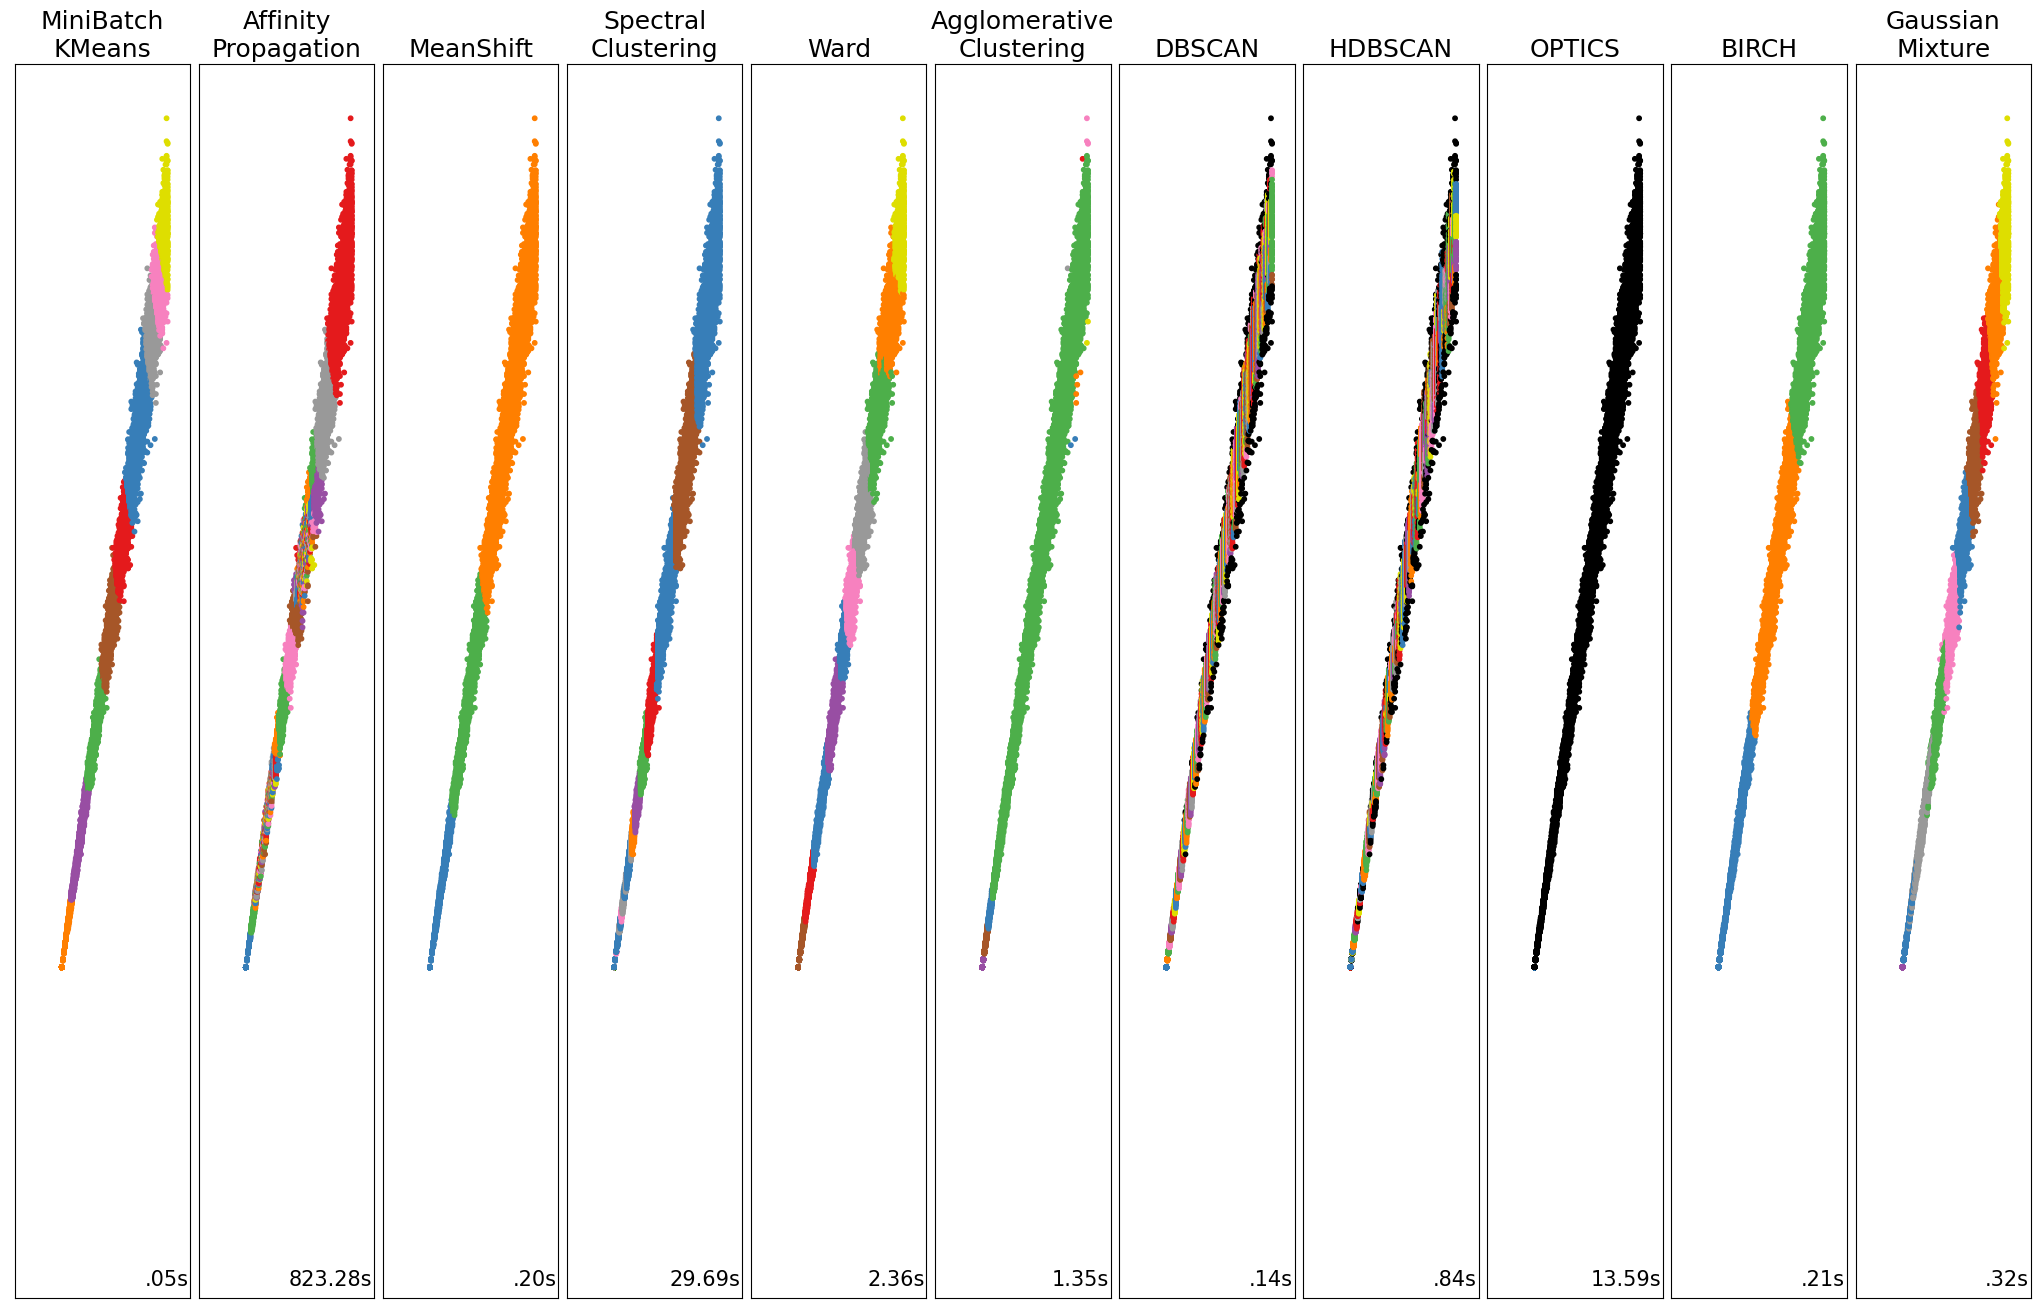

In [25]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
all_dataset = np.array([ df_all_jobs["n"], df_all_jobs["execution_time_ms"]], dtype=np.float64), None
X, y = all_dataset
X = np.transpose(X, axes=(1,0))
all_dataset = (X,y)

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

# ============
# Set up cluster parameters
# ============

default_base = {
    "quantile": 0.3,
    "eps": 0.02,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 30,
    "n_clusters": 10,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
}

datasets = [
    (all_dataset, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    print(len(X))

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )
    #clustering_algorithms = (
    #    ("DBSCAN", dbscan),
    #)
    #dbscan = cluster.DBSCAN(eps=params["eps"])

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()


